In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/Vincent2308/Corporate-Bankruptcy/refs/heads/main/data/clean/taiwan/taiwan.csv"

df= pd.read_csv(url)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.390923,0.428314,0.435356,0.601457,0.601457,0.998969,0.796887,0.808809,0.302963,...,0.075475,0.728578,0.009219,0.622879,0.601453,0.833419,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.028902,0.569389,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796630,0.808600,0.302963,...,0.025346,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.591105,0.591105,0.998700,0.796967,0.808966,0.303350,...,0.067250,0.739555,0.003252,0.622929,0.591105,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.047725,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.026205,0.569389,0.035490


In [2]:
df.info()
df['Bankrupt?'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 94 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

### Firm Size

We generate some values usiung the ratios available to try and approximate some values which relate to the size of the firm.

In [3]:
df["size_retained"] = df[" Retained Earnings to Total Assets"]
df["size_working_capital"] = df[" Working Capital to Total Assets"]
df["size_networth"] = df[" Net worth/Assets"]
df["size_current_liab"] = df[" Current Liability to Assets"]
df["size_op"] = df[" Operating Expense Rate"]


df["size_index"]= (df["size_retained"] + df["size_working_capital"] + df["size_networth"] +df["size_current_liab"]+df["size_op"] )
# we add 1.0001 to ensure the log is greater than 0 since that is undefined.
# We decided that 1.0001 was large enough to ensure it was positive to actualyl make a differece
# but not too large so that it would distort our resutls
df["log_size"] = np.log(df["size_index"]+ 1.0001)
 

### Multicolinearity

We remove highly correlated features.

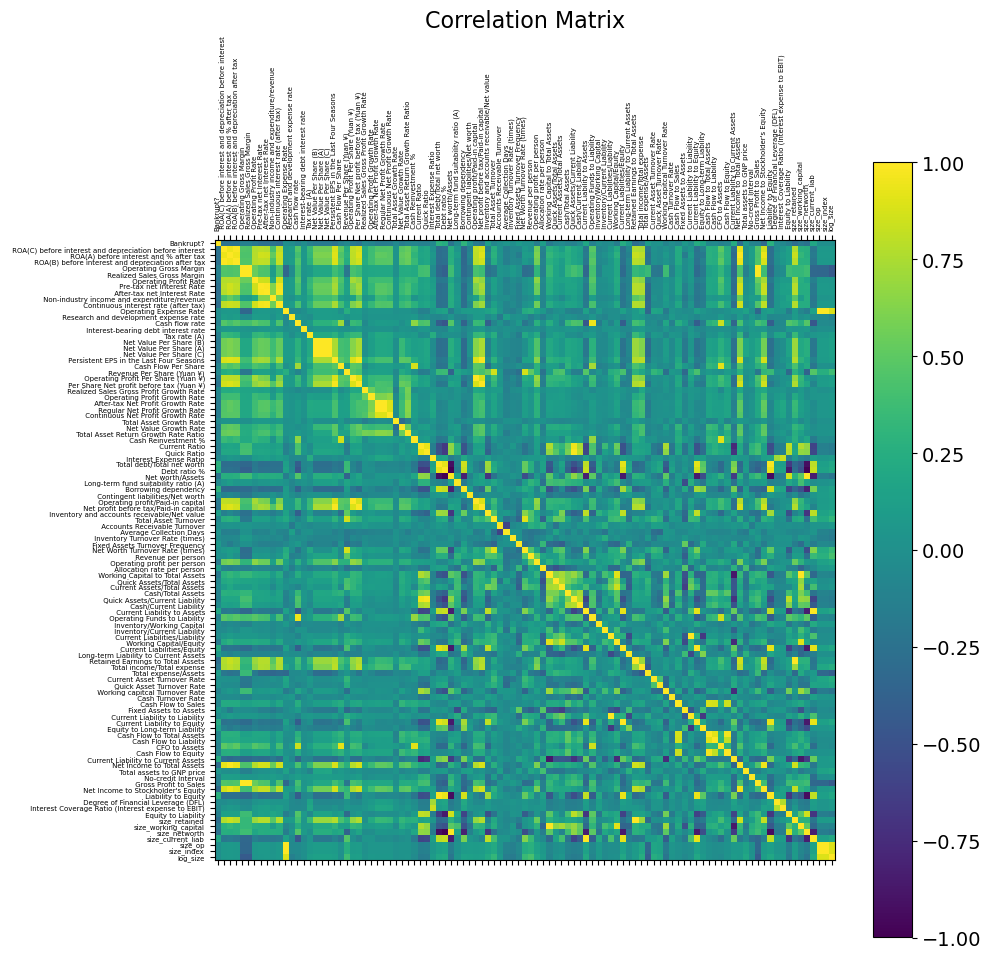

In [4]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=5, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [5]:
def remove_correlated(df, threshold=0.90):
    corr = df.corr().abs()

    # I used GPT for this part
    # it calculates the upper triangle above the diagonal since that has a corr of 1.
    # this avoids us calculating each correlation twice, since the correlation between A&B = corr B&A.
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    drop_cols = [c for c in upper.columns if any(upper[c] > threshold)]
    return df.drop(columns=drop_cols), drop_cols


In [6]:
df_reduced, dropped_columns = remove_correlated(df.drop(columns=["Bankrupt?"]))
df_reduced["Bankrupt?"] = df["Bankrupt?"]

df_reduced.head()


,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),...,Equity to Long-term Liability,Cash Flow to Total Assets,Current Liability to Current Assets,Total assets to GNP price,No-credit Interval,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,log_size,Bankrupt?
0,0.390923,0.601457,0.998969,0.796887,0.302963,1.256969e-04,0.0,0.458143,0.000725,0.0,...,0.126549,0.637555,0.075475,0.009219,0.622879,0.026601,0.564050,0.016469,1.268862,1
1,0.464291,0.610235,0.998946,0.797380,0.303556,2.897851e-04,0.0,0.461867,0.000647,0.0,...,0.120916,0.641100,0.047775,0.008323,0.623652,0.028902,0.569389,0.020794,1.272104,1
2,0.426071,0.601450,0.998857,0.796630,0.302963,2.361297e-04,25500000.0,0.458521,0.000790,0.0,...,0.117922,0.642765,0.025346,0.040003,0.623841,0.026555,0.563706,0.016474,1.289339,1
3,0.399844,0.591105,0.998700,0.796967,0.303350,1.078888e-04,0.0,0.465705,0.000449,0.0,...,0.120760,0.579039,0.067250,0.003252,0.622929,0.026697,0.564663,0.023982,1.275395,1
4,0.465022,0.598783,0.998973,0.797366,0.303475,7.890000e+09,0.0,0.462746,0.000686,0.0,...,0.110933,0.622374,0.047725,0.003878,0.623521,0.026205,0.569389,0.035490,22.788862,1


Text(0.5, 1.0, 'Correlation')

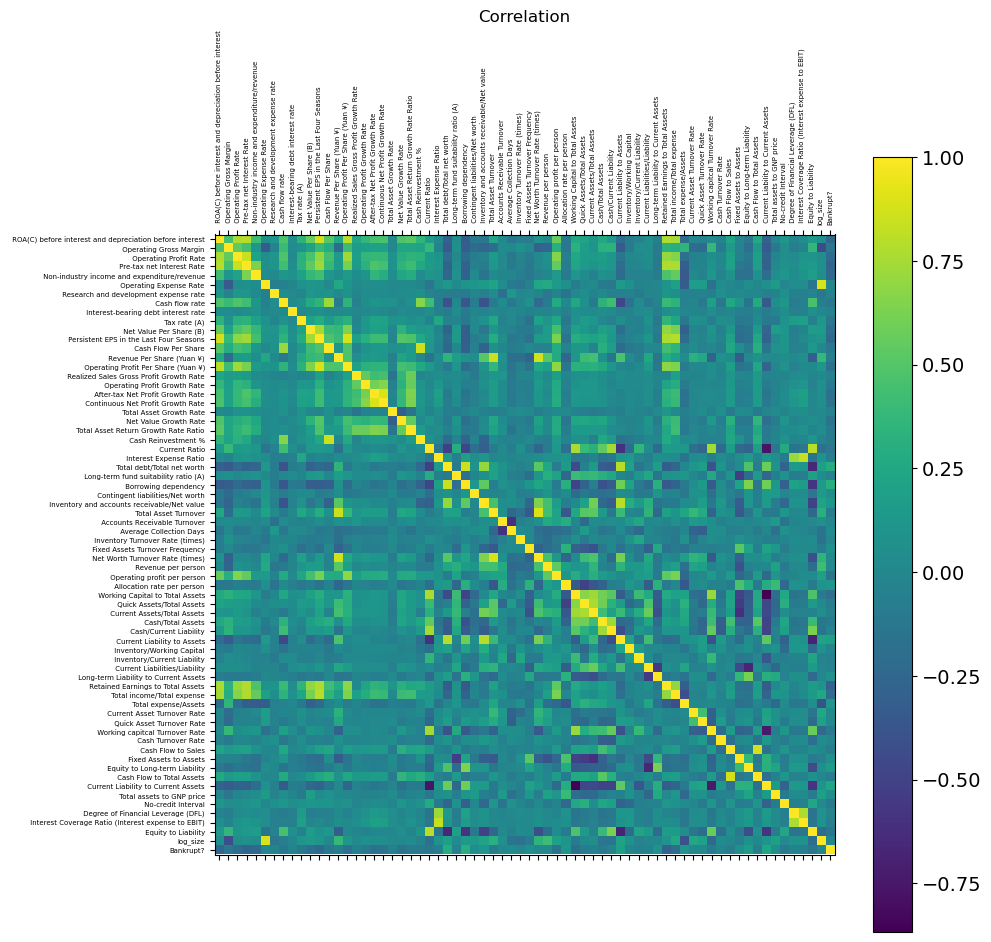

In [7]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df_reduced.corr(), fignum=f.number)
plt.xticks(range(df_reduced.select_dtypes(['number']).shape[1]), df_reduced.select_dtypes(['number']).columns, fontsize=5, rotation=90)
plt.yticks(range(df_reduced.select_dtypes(['number']).shape[1]), df_reduced.select_dtypes(['number']).columns, fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation')

### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

x = df_reduced.drop(columns=["Bankrupt?"])
y = df_reduced['Bankrupt?']

x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = 0.2, stratify =y, random_state = 42)

### Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)
x_test_sc  = scaler.transform(x_test)

### SMOTE

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
x_train_sc_sm, y_train_sm, = smote.fit_resample(x_train_sc, y_train)

### X.X Early-Warning Indicators
We could maybe add some more ratios, but they will probably have similar variances.

In [11]:
ratios=[" Current Liability to Assets"," Net Income to Total Assets"," Working Capital to Total Assets"," Retained Earnings to Total Assets"]
variance_df = df.groupby("Bankrupt?")[ratios].var()
variance_df


,Current Liability to Assets,Net Income to Total Assets,Working Capital to Total Assets,Retained Earnings to Total Assets
Bankrupt?,,,,
0,0.002101,0.000820,0.002936,0.000215
1,0.002337,0.000828,0.002264,0.000296


In [43]:
key_ratios = [" Working Capital to Total Assets", " Cash Flow to Total Assets", " Total debt/Total net worth"," Total Asset Turnover"]

grouped = df_reduced.groupby("Bankrupt?")[key_ratios]

stats = grouped.agg(["mean", "std", "var"])


var_df = stats.xs("var", axis=1, level=1)
var_df.index = var_df.index.map({0: "Healthy", 1: "Bankrupt"})
var_table = var_df.T
var_table.index.name = "Ratio"
var_table.columns = ["Healthy", "Bankrupt"]
var_table = var_table.round(3)

print(var_table)


mean_df = stats.xs("mean", axis=1, level=1)
std_df  = stats.xs("std", axis=1, level=1)
cv_df = std_df / mean_df
cv_df.index = cv_df.index.map({0: "Healthy", 1: "Bankrupt"})
cv_table = cv_df.T
cv_table.index.name = "Ratio"
cv_table.columns = ["Healthy", "Bankrupt"]
cv_table = cv_table.round(3)

print( cv_table)


                                 Healthy  Bankrupt
Ratio                                             
Working Capital to Total Assets    0.003     0.002
Cash Flow to Total Assets          0.001     0.001
Total debt/Total net worth         0.000     0.000
Total Asset Turnover               0.007     0.006
                                 Healthy  Bankrupt
Ratio                                             
Working Capital to Total Assets    0.066     0.063
Cash Flow to Total Assets          0.057     0.039
Total debt/Total net worth         0.777     0.415
Total Asset Turnover               0.612     0.733


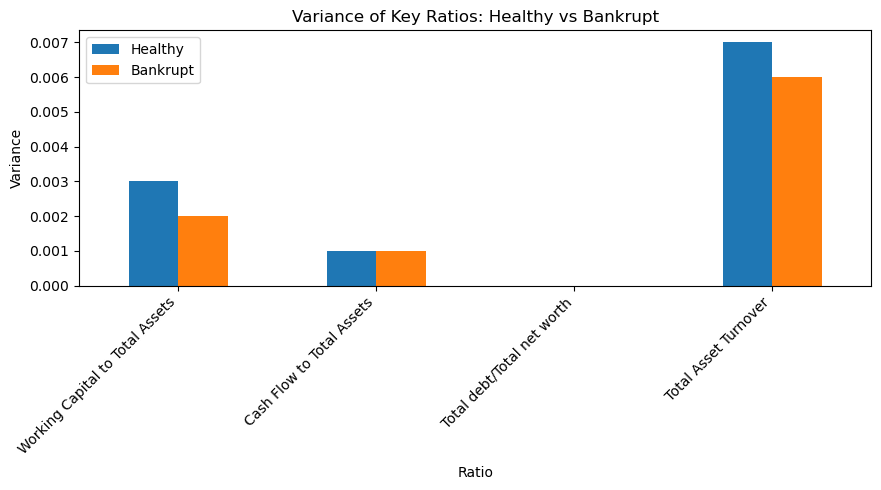

In [44]:
ax = var_table.plot(kind="bar", figsize=(9, 5))
ax.set_ylabel("Variance")
ax.set_title("Variance of Key Ratios: Healthy vs Bankrupt")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Model Evaluation Function

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay

def evaluate_model(model, x_test_sc, y_test):
    y_pred = model.predict(x_test_sc)
    y_prob = model.predict_proba(x_test_sc)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f'Accuracy: {acc:.3f}')
    print(f'Precision: {pre:.3f}')
    print(f'Recall: {rec:.3f}')
    print(f'F1-Score: {f1:.3f}')
    print(f'AUC Score: {auc:.3f}')

    RocCurveDisplay.from_estimator(model, x_test_sc, y_test)
    plt.show()

## Train Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Altman Z-Score

In [14]:
Z = (
    1.2 * df[" Working Capital to Total Assets"] +
    1.4 * df[" Retained Earnings to Total Assets"] +
    3.3 * df[" ROA(A) before interest and % after tax"] +
    1.0 * df[" Total Asset Turnover"]
)
df["Z-score"] = Z
roc_auc_score(y, -df["Z-score"])

0.8844697543704968

### Ohlson  O-Score

In [15]:
O = (
    -1.32
    +6.03* df[" Current Liability to Assets"]
    -1.43 * df[" Working Capital to Total Assets"]
    +0.0757 * df[" Current Liability to Current Assets"]
    -1.72 * (df[" Current Liability to Assets"] > 1).astype(int)
    -2.37 * df[" Net Income to Total Assets"]
)
df["O-score"] = O
roc_auc_score(y, df["O-score"])

0.8470722147983853

### Logistic Regression, without SMOTE

Accuracy: 0.880
Precision: 0.194
Recall: 0.864
F1-Score: 0.317
AUC Score: 0.944


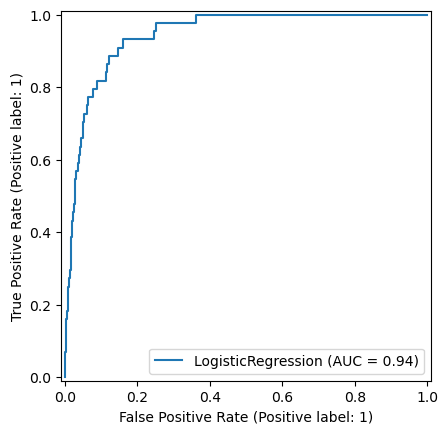

In [16]:
lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(x_train_sc, y_train)
evaluate_model(lr, x_test_sc, y_test)

### Logistic Regression + SMOTE

Accuracy: 0.883
Precision: 0.199
Recall: 0.864
F1-Score: 0.323
AUC Score: 0.945


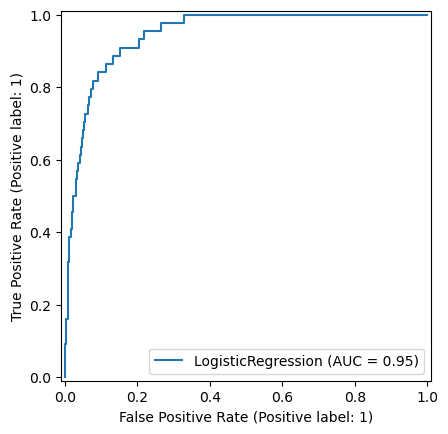

In [17]:
lr_sm = LogisticRegression(max_iter=500)
lr_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(lr_sm, x_test_sc, y_test)

### Logistic Regrssion PCA

Accuracy: 0.968
Precision: 0.545
Recall: 0.136
F1-Score: 0.218
AUC Score: 0.918


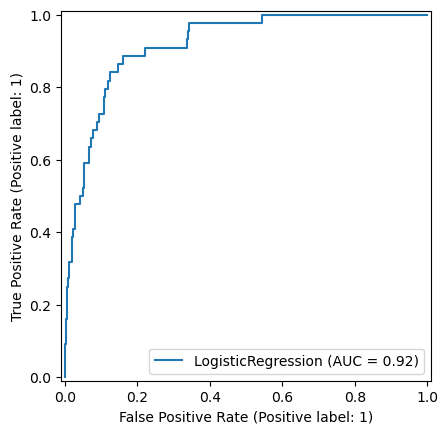

In [18]:
pca = PCA(n_components=1)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

lr_pca = LogisticRegression()
lr_pca.fit(x_train_pca, y_train)
evaluate_model(lr_pca, x_test_pca, y_test)

### Logistic Regrssion PCA + SMOTE

Accuracy: 0.548
Precision: 0.065
Recall: 0.977
F1-Score: 0.123
AUC Score: 0.918


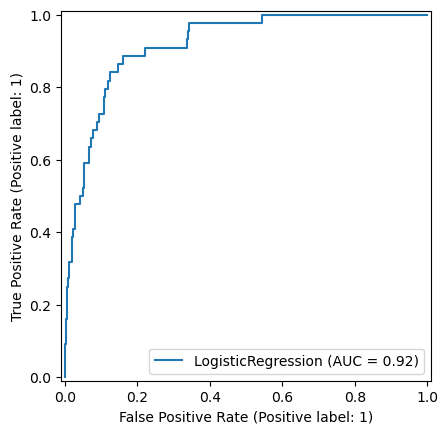

In [19]:
x_train_pca_sm = pca.fit_transform(x_train_sc_sm)
lr_pca_sm = LogisticRegression()
lr_pca_sm.fit(x_train_pca_sm, y_train_sm)
evaluate_model(lr_pca_sm, x_test_pca, y_test)

### Random Forest, without SMOTE


Accuracy: 0.972
Precision: 0.875
Recall: 0.159
F1-Score: 0.269
AUC Score: 0.954


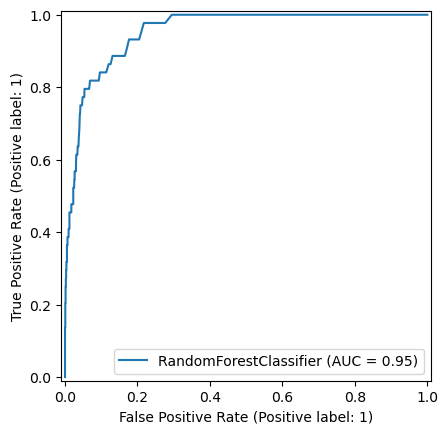

In [20]:
rf = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42)
rf.fit(x_train_sc, y_train)
evaluate_model(rf, x_test_sc, y_test)

### Random Forest + SMOTE


Accuracy: 0.967
Precision: 0.489
Recall: 0.523
F1-Score: 0.505
AUC Score: 0.951


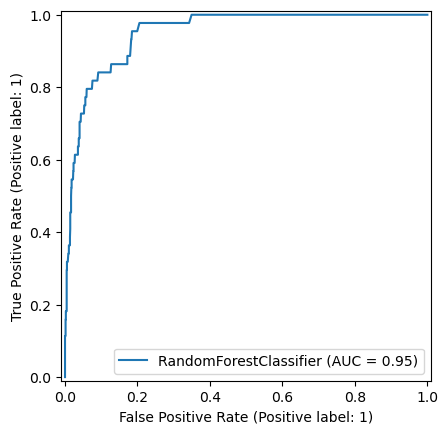

In [21]:
rf_sm = RandomForestClassifier(n_estimators=500, random_state=42)
rf_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(rf_sm, x_test_sc, y_test)

### Random forrest LDA without SMOTE

Accuracy: 0.961
Precision: 0.395
Recall: 0.386
F1-Score: 0.391
AUC Score: 0.864


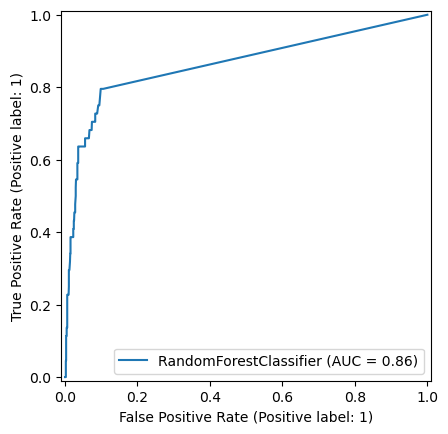

In [22]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(x_train_sc, y_train)
X_test_lda = lda.transform(x_test_sc)

rf_lda = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_lda.fit(X_train_lda, y_train)
evaluate_model(rf_lda, X_test_lda, y_test)

### Random forrest LDA + SMOTE

Accuracy: 0.621
Precision: 0.051
Recall: 0.614
F1-Score: 0.095
AUC Score: 0.745


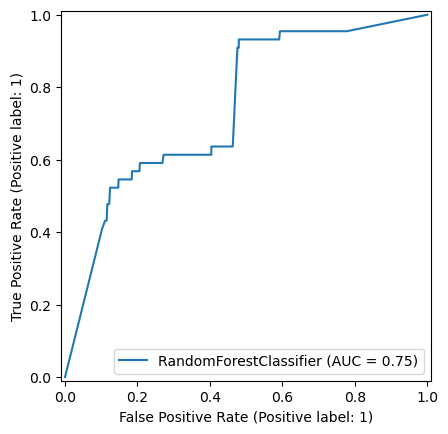

In [23]:
X_train_lda_sm = lda.fit_transform(x_train_sc_sm, y_train_sm)
rf_lda_sm = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_lda_sm.fit(X_train_lda_sm, y_train_sm)
evaluate_model(rf_lda_sm, X_test_lda, y_test)

### K-Nearest Neighbors, without SMOTE

Accuracy: 0.966
Precision: 0.455
Recall: 0.227
F1-Score: 0.303
AUC Score: 0.720


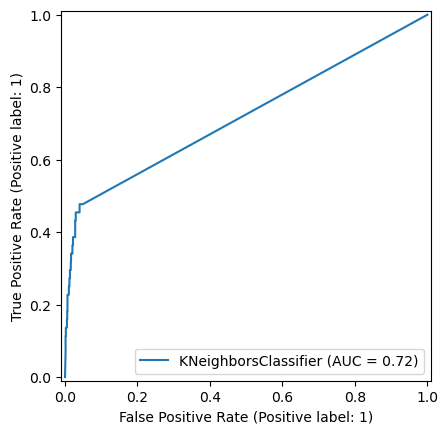

Accuracy: 0.968
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
AUC Score: 0.949


/opt/anaconda3/envs/bankruptcy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


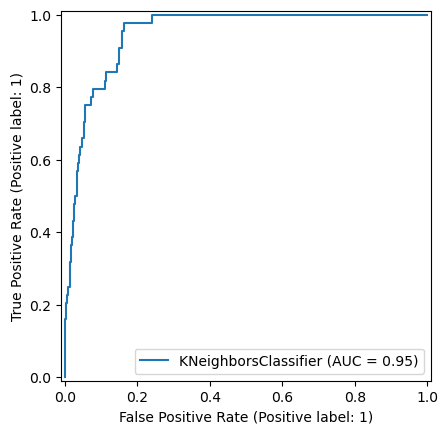

In [24]:
knn = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(x_train_sc, y_train)
    knn[str(k)] = model
    evaluate_model(knn[str(k)], x_test_sc, y_test)

### K-Nearest Neighbors + SMOTE

Accuracy: 0.911
Precision: 0.223
Recall: 0.705
F1-Score: 0.339
AUC Score: 0.860


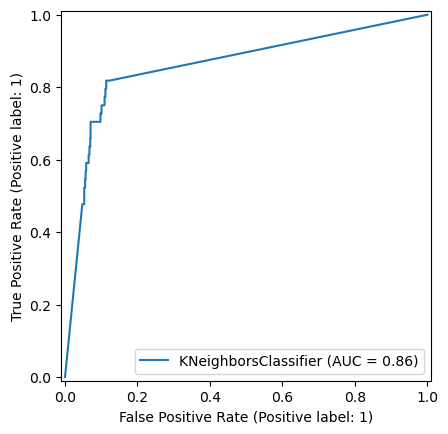

Accuracy: 0.814
Precision: 0.143
Recall: 0.955
F1-Score: 0.249
AUC Score: 0.950


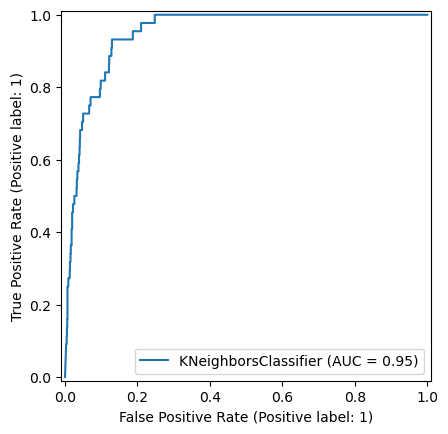

In [25]:
knn_sm = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(x_train_sc_sm, y_train_sm)
    knn_sm[str(k)] = model
    evaluate_model(knn_sm[str(k)], x_test_sc, y_test)

### XGBoost, without SMOTE


Accuracy: 0.967
Precision: 0.480
Recall: 0.273
F1-Score: 0.348
AUC Score: 0.948


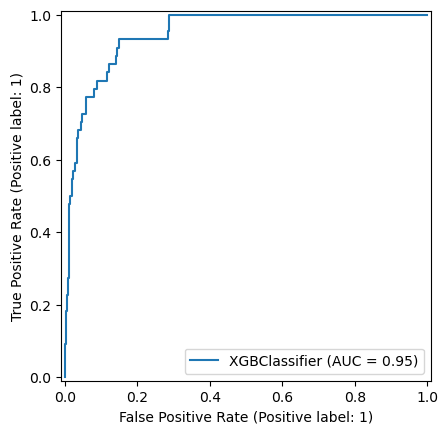

In [26]:
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(x_train_sc, y_train)
evaluate_model(xgb, x_test_sc, y_test)

### XGBoost + SMOTE


Accuracy: 0.971
Precision: 0.558
Recall: 0.545
F1-Score: 0.552
AUC Score: 0.952


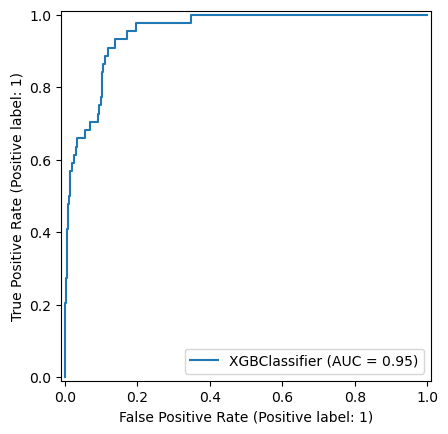

In [27]:
xgb_sm = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(xgb_sm, x_test_sc, y_test)

### Feature Importance

In [28]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)

coefficients_df = pd.DataFrame({
'Feature' : x.columns,
"Coefficients" : coefficients,
"Odds ratio" : odds_ratios
})

print(coefficients_df.sort_values(by="Coefficients", ascending=False))
coefficients_df.head(15)

fi_rf = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
fi_rf.head(15)

fi_xgb = pd.Series(xgb.feature_importances_,index=x.columns).sort_values(ascending=False)
fi_xgb.head(15)

                                              Feature  Coefficients  \
14                Operating Profit Per Share (Yuan ¥)      1.494636   
44                        Current Liability to Assets      1.134757   
39                    Working Capital to Total Assets      0.637211   
30                               Total Asset Turnover      0.625857   
25                         Total debt/Total net worth      0.582788   
..                                                ...           ...   
0    ROA(C) before interest and depreciation befor...     -0.551297   
50                         Total income/Total expense     -0.850603   
29        Inventory and accounts receivable/Net value     -1.135846   
13                         Revenue Per Share (Yuan ¥)     -1.190572   
11            Persistent EPS in the Last Four Seasons     -1.945139   

    Odds ratio  
14    4.457716  
44    3.110419  
39    1.891198  
30    1.869847  
25    1.791024  
..         ...  
0     0.576202  
50    0.427

 Net Value Growth Rate                          0.237134
 Borrowing dependency                           0.082759
 Total debt/Total net worth                     0.062502
 Persistent EPS in the Last Four Seasons        0.056352
 Total income/Total expense                     0.023286
 Net Value Per Share (B)                        0.021406
 Retained Earnings to Total Assets              0.020171
 Fixed Assets Turnover Frequency                0.016357
 Working Capital to Total Assets                0.015458
 Total Asset Growth Rate                        0.015402
 Non-industry income and expenditure/revenue    0.014317
 Interest Expense Ratio                         0.014234
log_size                                        0.013548
 Contingent liabilities/Net worth               0.012491
 Cash flow rate                                 0.012371
dtype: float32

## Model Comparisons

In [29]:
reduced_results = []

def add_result(name, model, data):
    # evaluate the mdodel based on the previoulsy chosen metrics
    y_pred = model.predict(data)

    # gets the predicted probability the the sample belongs to bankrupt = 1
    y_prob = model.predict_proba(data)[:,1]

    reduced_results.append({"Model": name,"Auc": roc_auc_score(y_test, y_prob),
        "Recall": recall_score(y_test, y_pred),"Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

add_result("Logistic regression", lr, x_test_sc)
add_result("Logistic regression (SMOTE)", lr_sm, x_test_sc)

add_result("RandomForest", rf, x_test_sc)
add_result("RandomForest (SMOTE)", rf_sm, x_test_sc)

add_result("XGBoost", xgb, x_test_sc)
add_result("XGBoost (SMOTE)", xgb_sm, x_test_sc)

add_result("KNN k=3", knn["3"], x_test_sc)
add_result("KNN k=3 (SMOTE)", knn_sm["3"], x_test_sc)

add_result("KNN k=99", knn["99"], x_test_sc)
add_result("KNN k=99 (SMOTE)", knn_sm["99"], x_test_sc)

add_result("Logistic regression PCA", lr_pca, x_test_pca)
add_result("Logistic regression PCA (SMOTE)", lr_pca_sm, x_test_pca)

add_result("Random forrest LDA", rf_lda, X_test_lda)
add_result("Random forrest LDA (SMOTE)", rf_lda_sm, X_test_lda)

print(knn["3"], knn["99"])


/opt/anaconda3/envs/bankruptcy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance') KNeighborsClassifier(n_jobs=-1, n_neighbors=99, weights='distance')


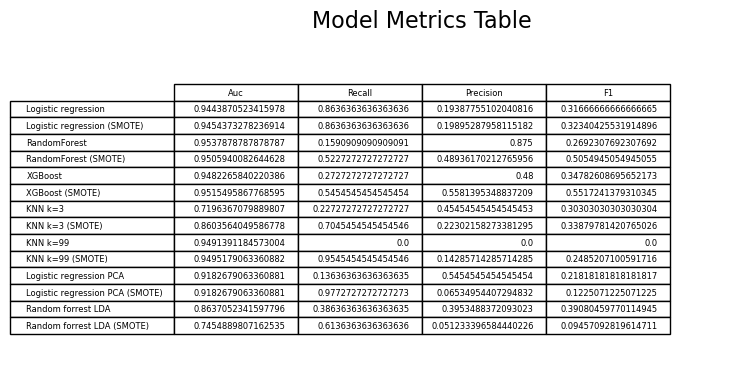

In [30]:
metrics_table = pd.DataFrame(reduced_results)
metrics_table_display = metrics_table[['Model', 'Auc', 'Recall', 'Precision', 'F1']]
metrics_table_display.set_index('Model', inplace=True)

plt.figure(figsize=(8, 4))
plt.axis('off')
plt.title("Model Metrics Table", fontsize=16, pad=20)
from pandas.plotting import table
table(plt.gca(), metrics_table_display, loc='center', colWidths=[0.2]*len(metrics_table_display.columns))
plt.show()



### Models Across Metrics


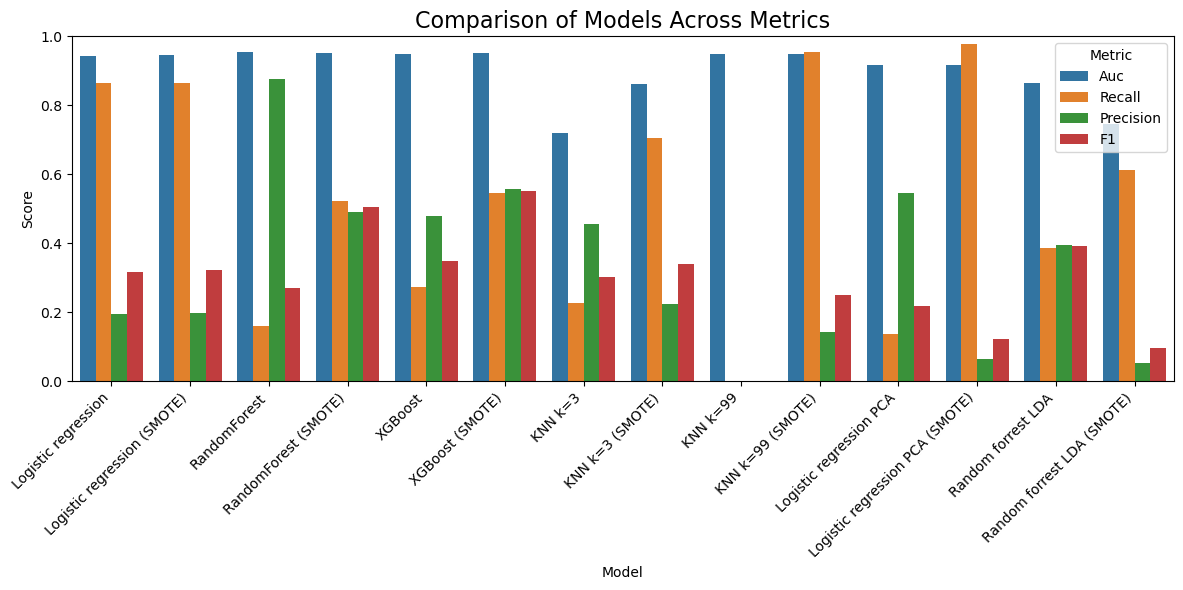

In [31]:
import seaborn as sns
metrics_melted = metrics_table.melt(id_vars="Model", value_vars=["Auc", "Recall", "Precision", "F1"], 
                                    var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Value", hue="Metric", data=metrics_melted)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Comparison of Models Across Metrics", fontsize=16)
plt.ylabel("Score")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

### ROC and Precision-Recall curves

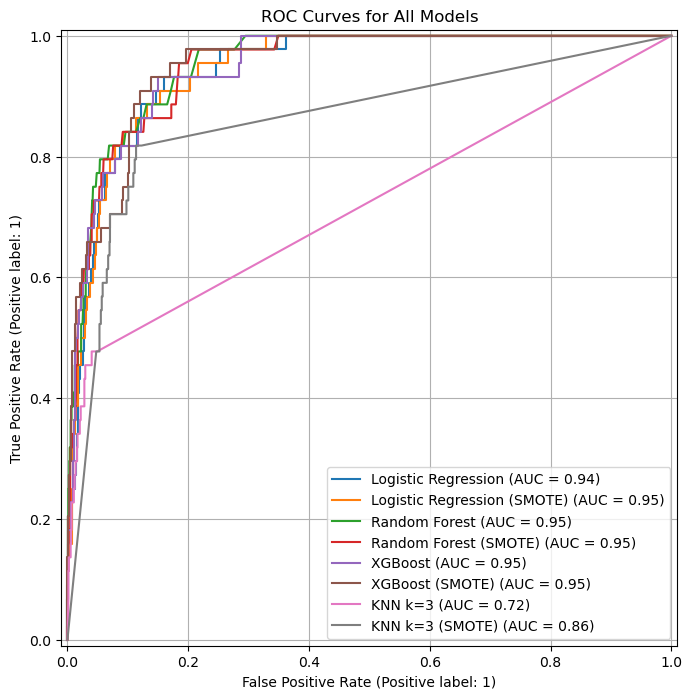

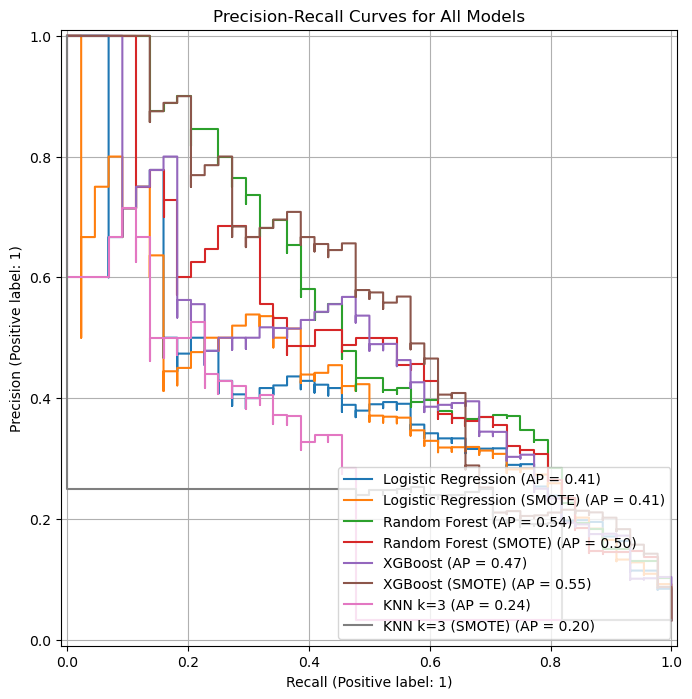

In [32]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# --- Define models and labels ---
models = {
    "Logistic Regression": lr,
    "Logistic Regression (SMOTE)": lr_sm,
    "Random Forest": rf,
    "Random Forest (SMOTE)": rf_sm,
    "XGBoost": xgb,
    "XGBoost (SMOTE)": xgb_sm,
    "KNN k=3": knn["3"],
    "KNN k=3 (SMOTE)": knn_sm["3"]
}

# --- ROC Curves ---
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(x_test_sc)[:,1]
    RocCurveDisplay.from_predictions(y_test, y_prob, name=name, ax=plt.gca())

plt.title("ROC Curves for All Models")
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.show()

# --- Precision-Recall Curves ---
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(x_test_sc)[:,1]
    PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=name, ax=plt.gca())

plt.title("Precision-Recall Curves for All Models")
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.show()


### Feature importance

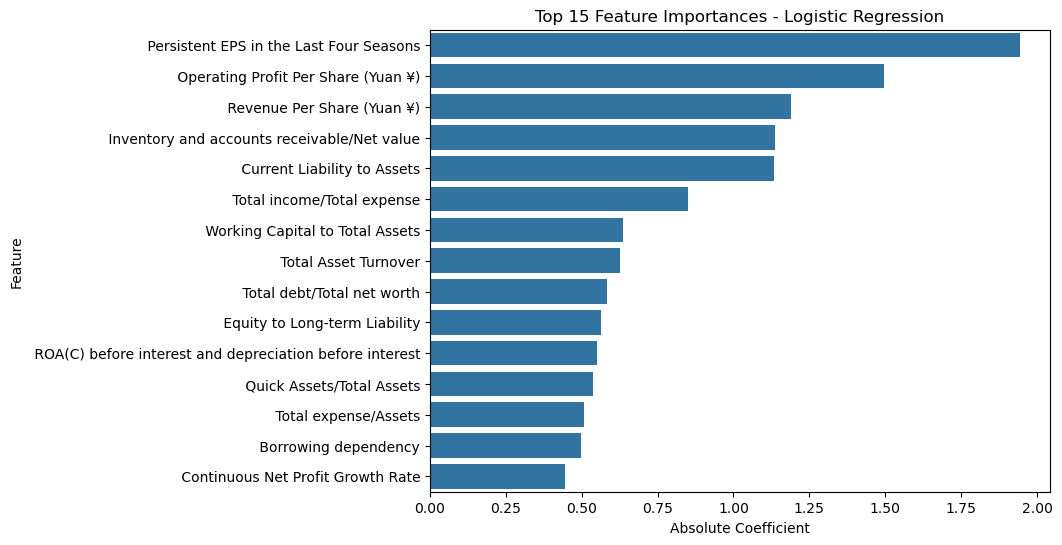

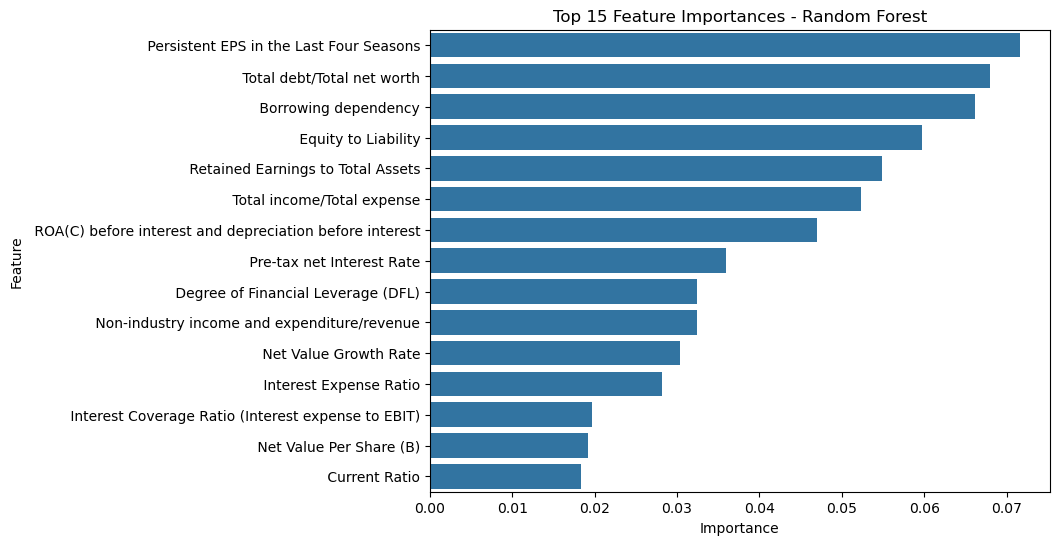

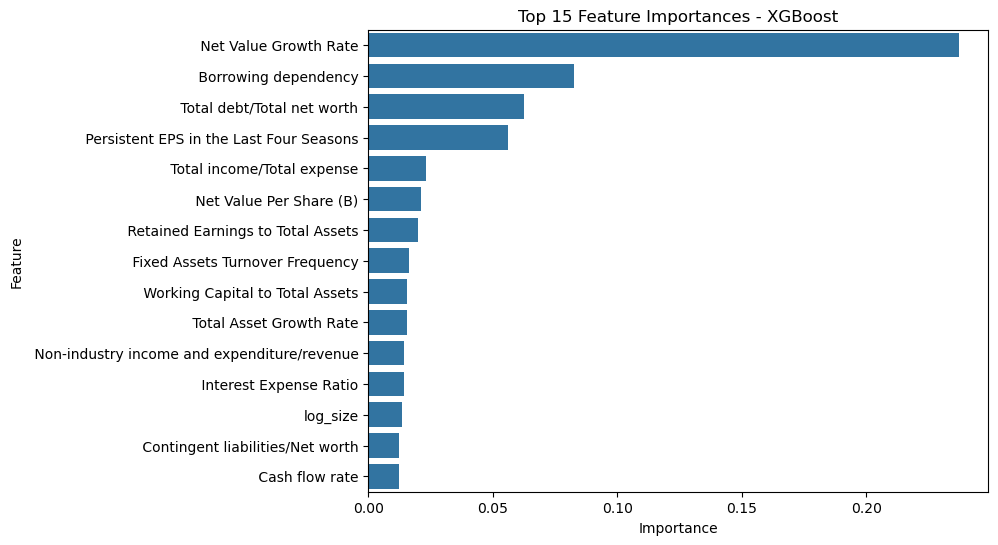

In [33]:
# Logistic Regression (absolute coefficients)
coef = pd.Series(np.abs(lr.coef_[0]), index=x.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(x=coef.values, y=coef.index)
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.show()

# Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# XGBoost
xgb_importances = pd.Series(xgb.feature_importances_, index=x.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()




# SMOTE Effect
 

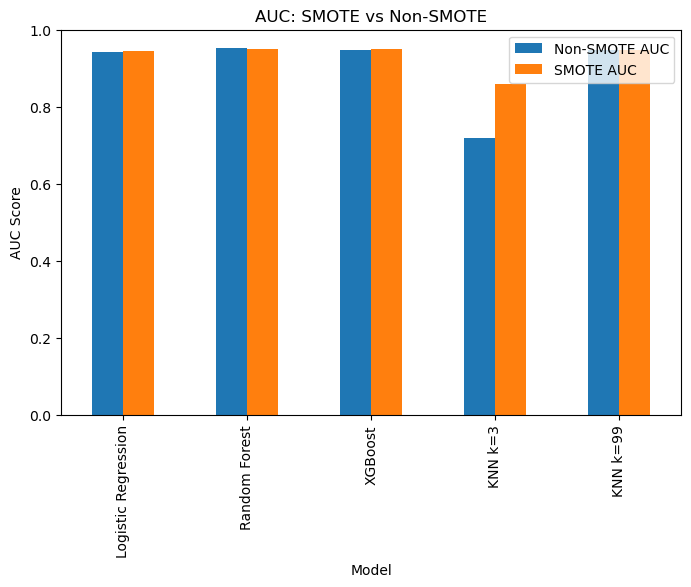

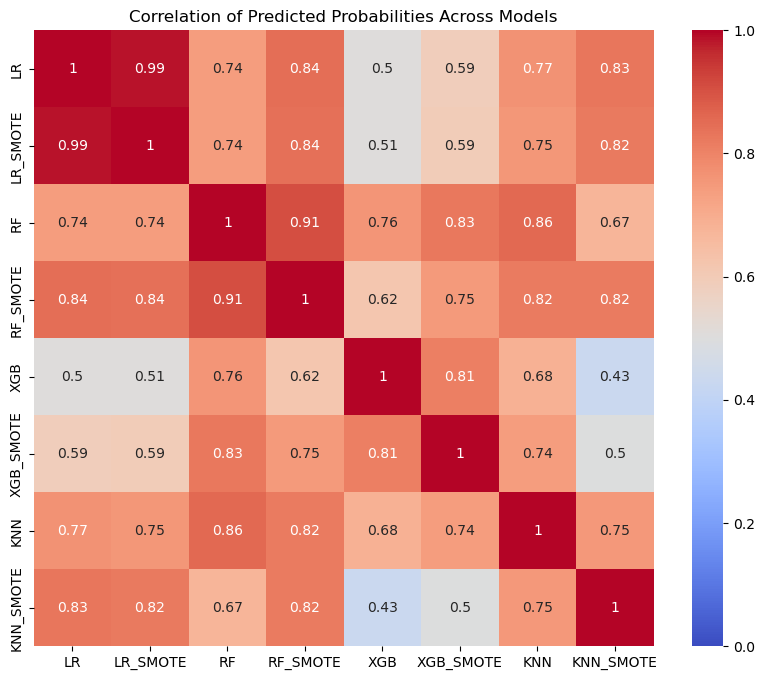

In [34]:
smote_metrics = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "KNN k=3", "KNN k=99"],
    "Non-SMOTE AUC": [
        roc_auc_score(y_test, lr.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, rf.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, xgb.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, knn["3"].predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, knn["99"].predict_proba(x_test_sc)[:,1])
    ],
    "SMOTE AUC": [
        roc_auc_score(y_test, lr_sm.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, rf_sm.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, xgb_sm.predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, knn_sm["3"].predict_proba(x_test_sc)[:,1]),
        roc_auc_score(y_test, knn_sm["99"].predict_proba(x_test_sc)[:,1])
    ]
})

smote_metrics.set_index("Model", inplace=True)
smote_metrics.plot(kind="bar", figsize=(8,5))
plt.title("AUC: SMOTE vs Non-SMOTE")
plt.ylabel("AUC Score")
plt.show()

# Collect predicted probabilities
pred_probs = pd.DataFrame({
    "LR": lr.predict_proba(x_test_sc)[:,1],
    "LR_SMOTE": lr_sm.predict_proba(x_test_sc)[:,1],
    "RF": rf.predict_proba(x_test_sc)[:,1],
    "RF_SMOTE": rf_sm.predict_proba(x_test_sc)[:,1],
    "XGB": xgb.predict_proba(x_test_sc)[:,1],
    "XGB_SMOTE": xgb_sm.predict_proba(x_test_sc)[:,1],
    "KNN": knn["3"].predict_proba(x_test_sc)[:,1],
    "KNN_SMOTE": knn_sm["3"].predict_proba(x_test_sc)[:,1],
    "KNN": knn["99"].predict_proba(x_test_sc)[:,1],
    "KNN_SMOTE": knn_sm["99"].predict_proba(x_test_sc)[:,1],
})

plt.figure(figsize=(10,8))
sns.heatmap(pred_probs.corr(), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation of Predicted Probabilities Across Models")
plt.show()



<Axes: xlabel='Model'>

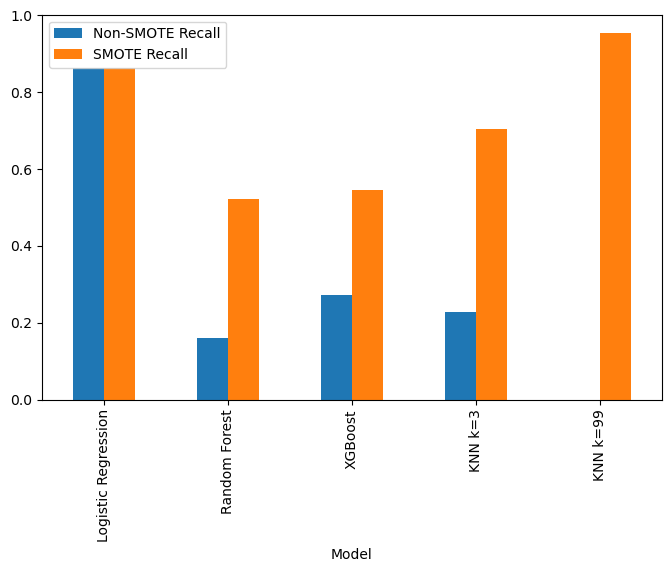

In [36]:
smote_metrics_recall = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "KNN k=3", "KNN k=99"],
    
    # NO SMOTE
    "Non-SMOTE Recall": [
        recall_score(y_test, lr.predict(x_test_sc)),
        recall_score(y_test, rf.predict(x_test_sc)),
        recall_score(y_test, xgb.predict(x_test_sc)),
        recall_score(y_test, knn["3"].predict(x_test_sc)),
        recall_score(y_test, knn["99"].predict(x_test_sc)),
    ],
    
    # WITH SMOTE
    "SMOTE Recall": [
        recall_score(y_test, lr_sm.predict(x_test_sc)),
        recall_score(y_test, rf_sm.predict(x_test_sc)),
        recall_score(y_test, xgb_sm.predict(x_test_sc)),
        recall_score(y_test, knn_sm["3"].predict(x_test_sc)),
        recall_score(y_test, knn_sm["99"].predict(x_test_sc)),
    ],
})

smote_metrics_recall.set_index("Model", inplace=True)
smote_metrics_recall.plot(kind="bar", figsize=(8,5))

